<a href="https://colab.research.google.com/github/stefanogiagu/corso_AI_2025/blob/main/Clustering_applied_to_VAE_latent_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Esercitazione E13: Representation Learning e Anomaly Detection con Auto-Encoders

scopo: familiarizzare con la progettazione e l'uso di architetture AE e con tecniche di Anomaly Detection

DL tool: pytorch

### tasks ###

1.   implementazione di un AE allenato come compressore di informazione e confronto con PCA
2.   uso di un AE come algoritmo di Anomaly Detection e applicazione al dataset MNIST
3.   esercizio: allenare un AE per Anomaly Detection di decadimenti di particelle a liunga vita media in un rivelatore di fisica delle alte energie


**Datasets:**

*   [MNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST)
*   LLP: immagini che rappresentano decadimenti prompt (eventi normali) e decadimenti di particelle a lunga vita media (eventi anomali) in un rivelatore per muoni di un esperimenti di fisica al collider LHC

In [ ]:
# import delle librerie
import numpy as np
import matplotlib.pyplot as plt

# pytorch
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

from torch import nn
import torch.nn.functional as F

2.6.0+cu124
0.21.0+cu124


il dataset MNIST è costituito da immagini di caratteri numerici (0,1,...,9) scritti a mano corrispondenti a 60k immagini per il training e 10k immagini per il test.

Ogni immagine ha dimensione $(28,28)$ pixel, con un canale di intensità (scala di grigi) a 8 bit (valori di intensità di ogni pixel $\in [0,255]$).

È disponibile in varie librerie per il ML (scikit-learn, torch, tensorflow, librerie esterne...). Prendendo il dataset già disponibile in pytorch possiamo sfruttare il vantaggio di di avere conversioni automatiche in tensori torch e normalizzazioni. Leggendo il dataset da un repository esterno a pytorch come ad esempio openm, in formato di ndarray numpy, dovremo convertire noi i vettori in tensori torch e normalizzarli, ma risulterà più chiaro come usare in generale datset esterni. in questo hands-on utilizzeremo questo secondo approccio.

In [ ]:
# lettura del dataset MNIST da openml usando la libreria sklearn

from sklearn.datasets import fetch_openml

images, labels = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, parser="pandas")
labels = labels.astype(int) # converte le label in int

print(images.shape)
print(labels.shape)

(70000, 784)
(70000,)


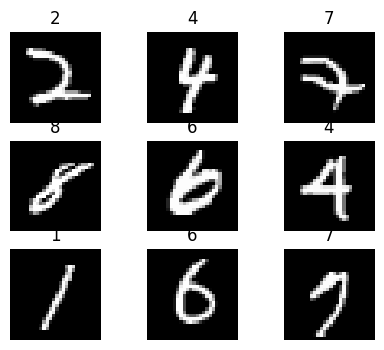

In [ ]:
# grafichiamo 9 immagini random
figure = plt.figure(figsize=(5, 4))
cols, rows = 3,3
for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(images))
    img, label = images[sample_idx], labels[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.reshape((28,28)), cmap="gray")
plt.show()

In [ ]:
# splitting del campione in training e test (80:20)

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.2, shuffle=True, random_state=12345)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(56000, 784)
(56000,)
(14000, 784)
(14000,)


In [ ]:
# le immagini MNIST sono immagini in scala di grigio a 8 bit, ogni pixel assume valore [0,255], quindi in quetso caso è possibile
# normalizzare in [0,1] semplicemente dividendo tutte le immagini per 255

X_train = X_train / 255.
X_test  = X_test / 255.

In [ ]:
# per questa esercitazione è consigliabile usare una GPU
# controlliamo se la GPU è disponibile e nel caso quale tipo di GPU
if torch.cuda.is_available():
  print('Numero di GPU disponibili: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

# se la GPU è disponibile setto device='cuda', altrimenti 'cpu
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Numero di GPU disponibili:  1
Tesla T4
Computation device: cuda



In [ ]:
# conversione in tensori torch dei vettori numpy

X_train_pt = torch.Tensor(X_train).float()
Y_train_pt = torch.Tensor(Y_train).int()
X_test_pt = torch.Tensor(X_test).float()
Y_test_pt = torch.Tensor(Y_test).int()

# reshape the tensori da (n,784) a (n,1,28,28)=(evento, channel, h size, v size) come richiesto da conv layer in pytorch

X_train_pt = X_train_pt.view((X_train_pt.shape[0],1,28,28))
X_test_pt = X_test_pt.view((X_test_pt.shape[0],1,28,28))

print(X_train_pt.shape)
print(Y_train_pt.shape)
print(X_test_pt.shape)
print(Y_test_pt.shape)

torch.Size([56000, 1, 28, 28])
torch.Size([56000])
torch.Size([14000, 1, 28, 28])
torch.Size([14000])


In [ ]:
# dataset e dataloaders

batch_size = 128

from torch.utils.data import TensorDataset, DataLoader

dataset_train = TensorDataset(X_train_pt, Y_train_pt)
train_dl = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)

dataset_test = TensorDataset(X_test_pt, Y_test_pt)
test_dl = DataLoader(dataset_test, batch_size=1, shuffle=True, drop_last=True)

### Definzione del modello di rete neurale.

Archiettura: AE convoluzionale con encoder costituito da 2 layer convoluzionali 2D con kernel_size 4 e stride 2 (per comprimere le rappresentazioni), decoder costituito da ConvTranspose2D. Lo spazio latente z è costituito da un layer denso. Usiamo attivazioni ReLu nella parte convoluzionale e sigmoide nell'output in modo da avere un output con ogni pixel in [0,1] e allenare il modello con BCELoss.

In [ ]:
# Convolutional Encoder Model

class Encoder(nn.Module):
    def __init__(self, hidden_channels=64, latent_dim=2):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=hidden_channels,
                            stride=2,
                                 kernel_size=4,
                                padding=1)
        self.conv2 = nn.Conv2d(in_channels=hidden_channels,
                               out_channels=hidden_channels*2,
                               kernel_size=4,
                               stride=2,
                               padding=1) # output: hidden_channels x 2 x 7 x 7

        self.fc_z = nn.Linear(in_features=hidden_channels*2*7*7,
                               out_features=latent_dim)

        self.activation = nn.ReLU()

    def forward(self, x):

        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))

        x = x.flatten(start_dim=1) #flatten da [-1, 2*hidden channels, 7, 7] a [-1, 2*hidden channels*7*7]

        z = self.fc_z(x)

        return z

In [ ]:
# Convolutional Decoder Model
# basato su nn.ConvTranspose2d transpose convolution layer

class Decoder(nn.Module):
    def __init__(self, hidden_channels=64, latent_dim=2):
        super().__init__()
        self.hidden_channels = hidden_channels

        self.fc = nn.Linear(in_features=latent_dim,
                            out_features=hidden_channels*2*7*7)

        self.conv2 = nn.ConvTranspose2d(in_channels=hidden_channels*2,
                                        out_channels=hidden_channels,
                                        kernel_size=4,
                                        stride=2,
                                        padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=hidden_channels,
                                        out_channels=1,
                                        kernel_size=4,
                                        stride=2,
                                        padding=1)

        self.activation = nn.ReLU()


    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), self.hidden_channels*2, 7, 7)
        x = self.activation(self.conv2(x))
        out = torch.sigmoid(self.conv1(x)) # final activation sigmoid (works with BCELoss as reconstruction loss)
        return out

In [ ]:
# Full AE Model

class AE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z = self.encoder(x)       # x-> z
        x_recon = self.decoder(z) # z -> x'

        return x_recon

In [ ]:
# Instanziamo il modello

hidden_channels = 64 #numero filtri convoluzionali primo layer conv.
latent_dim = 16 #dimensione dello spazio latente z

encoder = Encoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
decoder = Decoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
model_ae = AE(encoder, decoder)

print(model_ae)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model_ae.cuda(), input_size=(1,28,28))
else:
  summary(model_ae, input_size=(1,28,28))

AE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_z): Linear(in_features=6272, out_features=16, bias=True)
    (activation): ReLU()
  )
  (decoder): Decoder(
    (fc): Linear(in_features=16, out_features=6272, bias=True)
    (conv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv1): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (activation): ReLU()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,088
              ReLU-2           [-1, 64, 14, 14]               0
            Conv2d-3            [-1, 128, 7, 7]         131,200
              ReLU-4            [-1, 128, 7, 7]               0
            Linear-5                   [-1, 1

In [ ]:
# testiamo il modello su un batch

model_ae=model_ae.to(device)

x,_ = next(iter(train_dl)) #è un AE non ci servono le label

x=x.to(device)

z = encoder(x)
xtilde = model_ae(x)


print(z.shape)
print(xtilde.shape)

torch.Size([128, 16])
torch.Size([128, 1, 28, 28])


In [ ]:
# Training


# Istanziamo un nuovo modello

hidden_channels = 64
latent_dim = 16 #dimensione dello spazio latente z

encoder = Encoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
decoder = Decoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
model_ae = AE(encoder, decoder)

model_ae = model_ae.to(device)

# Loss Binary CrossEntropy (qui implementata a mano per far vedere come si può scrivere una custom loss (utile per future eserecitazioni),
# ma si potrebbe semplicemente usare nn.BCELoss()

def ae_loss(recon_x, x):
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784))
    return recon_loss

# Optimizer
LR = 1.e-3
opt = torch.optim.Adam(params=model_ae.parameters(), lr=LR, weight_decay=1e-5)

In [ ]:
# Training loop ... basta solo il loop sul training per fare prima ...

import time

epochs = 60
hist_loss = []

for epoch in range(epochs):
    t0 = time.time()

    # training step
    model_ae.train()
    train_loss = 0
    counter = 0

    for xb, _ in train_dl:
        counter += 1
        xb=xb.to(device)

        xhat = model_ae(xb)
        loss = ae_loss(xhat, xb)

        train_loss += loss.item()

        # backpropagation
        opt.zero_grad()
        loss.backward()
        opt.step()


    train_loss /= counter
    hist_loss.append(train_loss)

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f"
          % (epoch+1, elapsed_time, train_loss))

epoch: 1, time(s): 2.7574, train loss: 0.142750
epoch: 2, time(s): 2.7093, train loss: 0.097751
epoch: 3, time(s): 2.7925, train loss: 0.092889
epoch: 4, time(s): 2.7826, train loss: 0.090623
epoch: 5, time(s): 2.7435, train loss: 0.089122
epoch: 6, time(s): 2.7586, train loss: 0.088167
epoch: 7, time(s): 2.7911, train loss: 0.087391
epoch: 8, time(s): 2.8108, train loss: 0.086831
epoch: 9, time(s): 2.7773, train loss: 0.086353
epoch: 10, time(s): 2.7853, train loss: 0.086045
epoch: 11, time(s): 2.7857, train loss: 0.085692
epoch: 12, time(s): 2.8252, train loss: 0.085465
epoch: 13, time(s): 2.7697, train loss: 0.085217
epoch: 14, time(s): 3.3209, train loss: 0.085006
epoch: 15, time(s): 2.7400, train loss: 0.084871
epoch: 16, time(s): 2.7842, train loss: 0.084702
epoch: 17, time(s): 2.7413, train loss: 0.084519
epoch: 18, time(s): 2.7263, train loss: 0.084463
epoch: 19, time(s): 2.7163, train loss: 0.084328
epoch: 20, time(s): 3.0934, train loss: 0.084170
epoch: 21, time(s): 2.7275, t

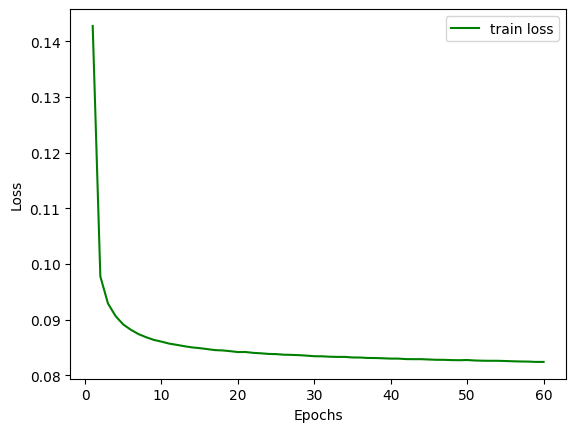

In [ ]:
# training loss plot
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

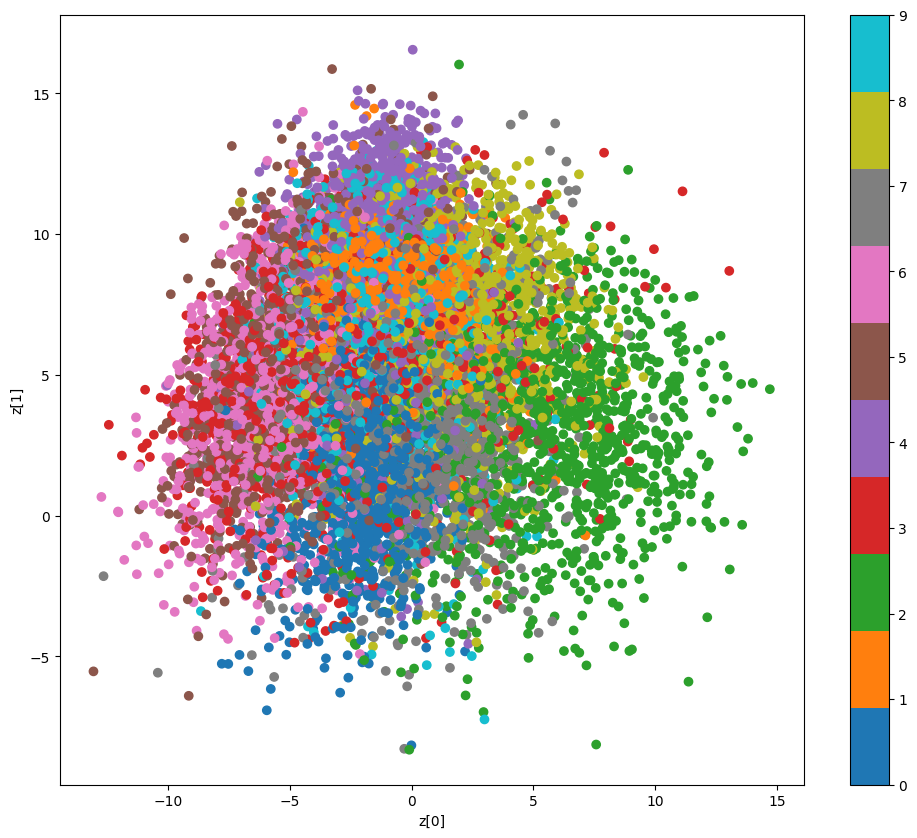

In [ ]:
# Plot dello spazio latente appreso (z1 vs z2)

model_ae.eval()

z = np.empty(shape=(len(test_dl),16))
y = np.empty(shape=(len(test_dl)))
x_im = np.empty(shape=(len(test_dl),28*28))
counter = 0
with torch.no_grad():
  for idx, (xb, yb) in enumerate(test_dl):
    xb=xb.to(device)
    zl = encoder(xb)
    #print(zl.shape)
    #print(xb.shape)
    z[idx,:] = zl[0,:].cpu().numpy()
    #z[idx,1] = zl[0,1].item()
    y[idx] = yb.item()
    x_im[idx,:] = xb.view(28*28).cpu().numpy()# immagine come array 1D

plt.figure(figsize=(12, 10))
plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

In [ ]:
print("dim dataset encoded (latent space)", z.shape)
print("dim del dataset nello spazio immagine", x_im.shape)

dim dataset encoded (latent space) (14000, 16)
dim del dataset nello spazio immagine (14000, 784)


In [ ]:
# plot della riduzione dim dello spazio latente con PCA e t-sne
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)# mi definisce una matrice di rotazione 16x16
pca_result = pca.fit_transform(z)# pca = Rz prendo solo le prime due componenti

In [ ]:
# plot della riduzione dim dello spazio latente con PCA e t-sne
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)# mi definisce una matrice di rotazione 16x16
pca_result = pca.fit_transform(np.random.rand(*z.shape))# pca = Rz prendo solo le prime due componenti

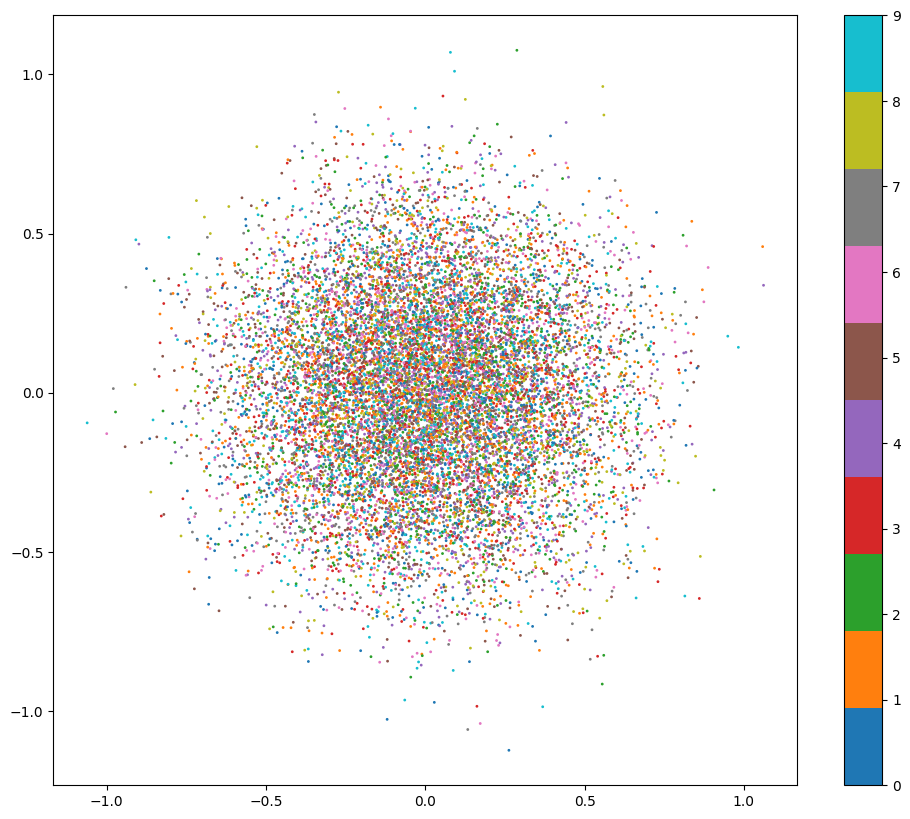

In [ ]:
pca_result.shape
#plot
plt.figure(figsize=(12, 10))
plt.scatter(pca_result[:, 0], pca_result[:, 1],s=1, c=y, cmap='tab10')
plt.colorbar()

In [ ]:
# con clustering k-mean
from sklearn.cluster import KMeans
z_random = np.concatenate([0.5*np.random.randn(200,2), (0.5*np.random.randn(200,2)+1), (np.random.randn(200,2)-1)],axis=0)
pca = PCA(n_components=2)# mi definisce una matrice di rotazione 16x16
pca_result = pca.fit_transform(z_random)# pca = Rz prendo solo le prime due componenti
kmeans = KMeans(n_clusters=3, random_state=0).fit(z_random)

In [ ]:
# siluette score
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

for c in range(2,4):
  kmeans = KMeans(n_clusters=c, random_state=123).fit(z_random)
  gmm = GaussianMixture(n_components=c, random_state=45,covariance_type='diag').fit(z_random)
  sil_km= silhouette_score(z_random, kmeans.labels_).round(3)
  sil_gm= silhouette_score(z_random, gmm.predict(z_random)).round(3)
  print(f"siluette for {c}- KM : {sil_km}, GMM : {sil_gm}")

siluette for 2- KM : 0.455, GMM : 0.456
siluette for 3- KM : 0.404, GMM : 0.394


In [ ]:
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1,

In [ ]:
consenso = gmm.predict(z_random)==kmeans.labels_

In [ ]:
gmm.predict(z_random)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2,

In [ ]:
consenso*3

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

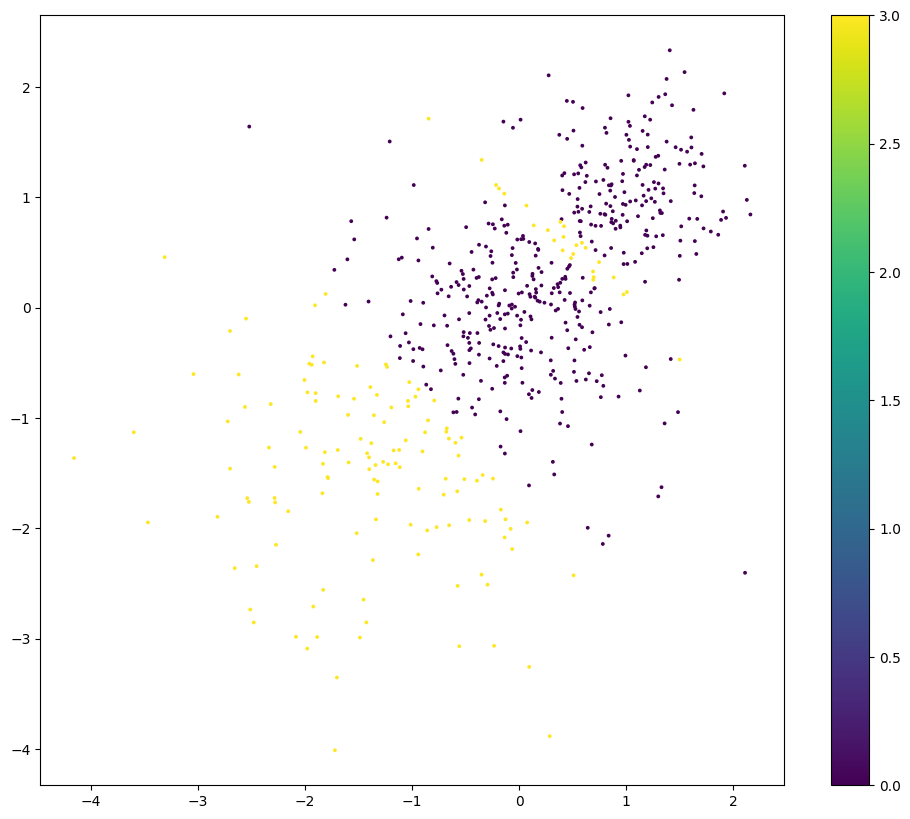

In [ ]:
#plot
plt.figure(figsize=(12, 10))
plt.scatter(z_random[:, 0], z_random[:, 1],s=3, c=consenso*3)
plt.colorbar()

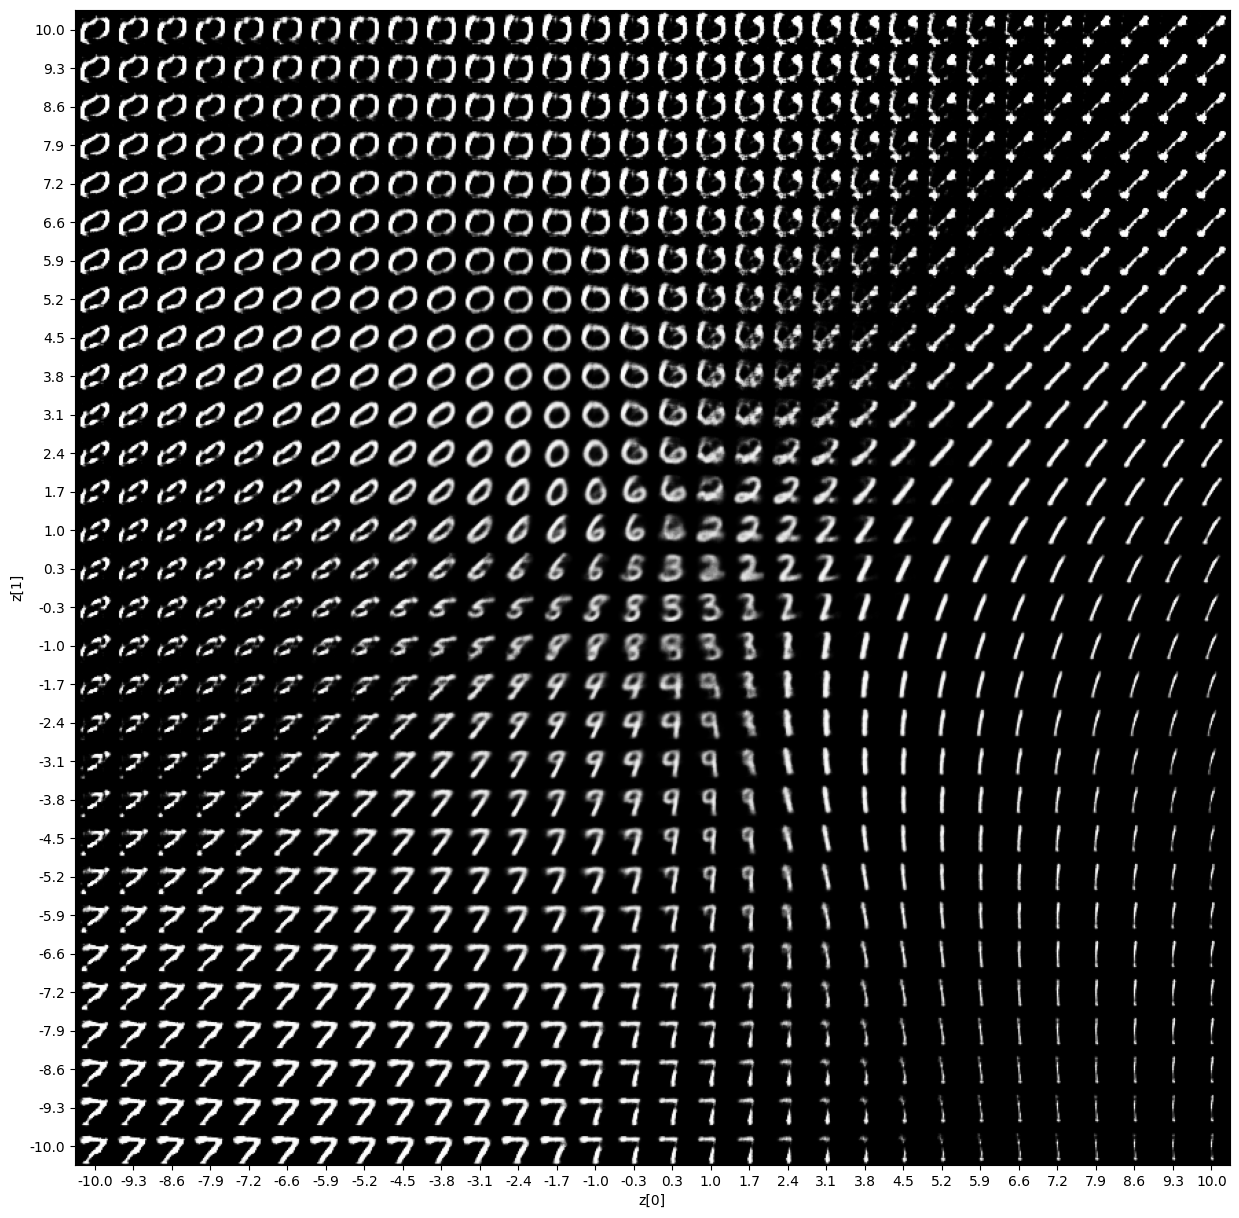

In [ ]:
# plot della mapa z -> immagine

# plotta una matrice nxn di immagini generate dal decoder della AE ottenute facendo uno scan delle due dimensioni latenti [z1,z2]
# cercate di capire cosa fa questa funzione

model_ae.eval()
def plot_latent(decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 10
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([xi, yi]).float() #vettore z
            z_sample = z_sample.view(1,2)
            z_sample=z_sample.to(device)
            x_decoded = decoder(z_sample) #decoder(z)
            x_decoded=x_decoded.cpu()
            digit = x_decoded[0].view(28,28).detach().numpy() #(1,28,28) -> (28,28)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    #print(pixel_range)
    #print(sample_range_x)
    #print(sample_range_y)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent(decoder)

**Confronto con PCA**

explained variance componente:  0  =  0.09771438416479672
explained variance componente:  1  =  0.0727458350809783
Explained variance totale delle prime 2 componenti della PCA: 0.17046021924577504


Text(0, 0.5, '$PCA_1$')

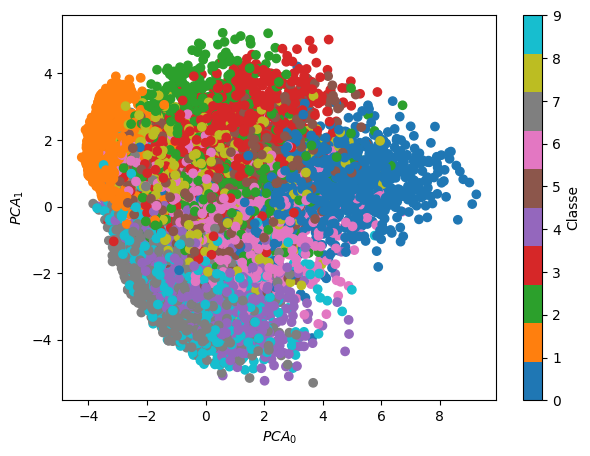

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

pca_result = pca.fit_transform(X_test)

exp_var = pca.explained_variance_ratio_

for i in range(0,len(exp_var)):
  print('explained variance componente: ',i, ' = ', exp_var[i])
print('Explained variance totale delle prime 2 componenti della PCA: {}'.format(sum(exp_var)))

import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.scatter(pca_result[:,0], pca_result[:,1], c=Y_test, cmap='tab10')
cbar = plt.colorbar()
cbar.set_label('Classe')
plt.xlabel('$PCA_0$')
plt.ylabel('$PCA_1$')

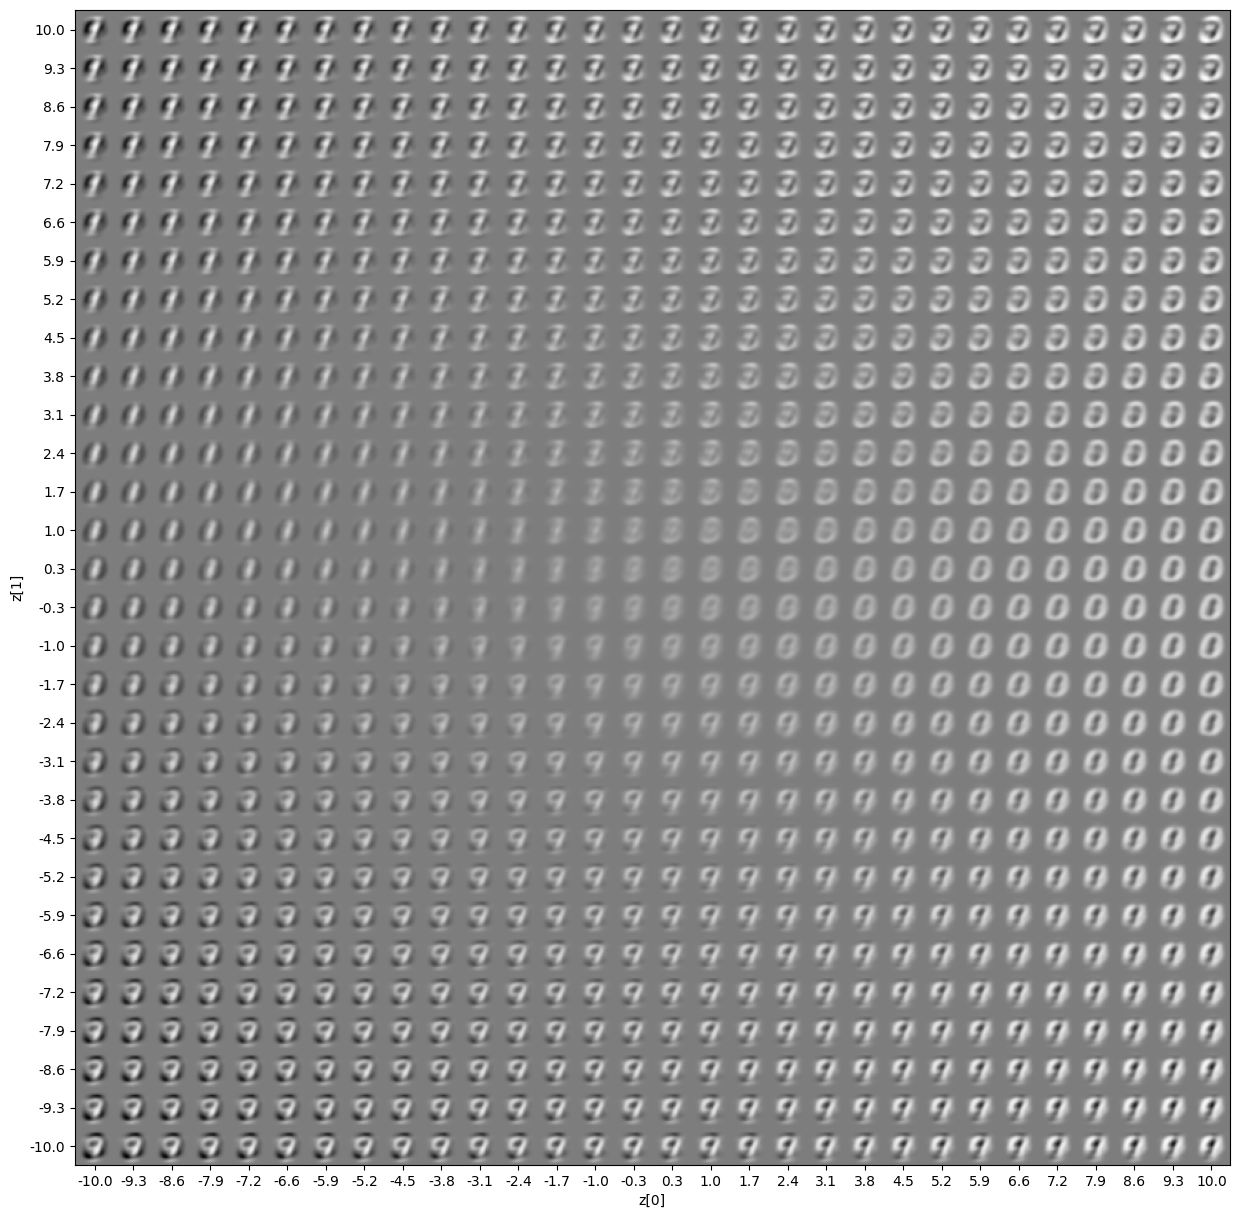

In [ ]:
# plot della mappa pca -> immagine

# plotta una matrice nxn di immagini generate dalla PCA ottenute facendo uno scan delle due dimensioni latenti [pca1,pca2]
# cercate di capire cosa fa questa funzione e in cosa differsice da quella usata per l'AE

def plot_latent_pca():
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 10
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([xi, yi]) #vettore z
            x_decoded = pca.inverse_transform(z_sample) #inversa della PCA
            digit = x_decoded.reshape((28,28))
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    #print(pixel_range)
    #print(sample_range_x)
    #print(sample_range_y)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_pca()

## Uso dell'AE come Anomaly Detector

Il rilevamento delle anomalie descrive una classe di algoritmi che mira all'identificazione di elementi, eventi o osservazioni rari, che si discostano in modo significativo dalla maggior parte dei dati e non sono conformi a una nozione ben definita di comportamento normale.

L'idea è quella di allenare l'AE solo con un tipo di eventi (normali), e poi usare la cross entropia tra input e output ricostruito oppure una aggregazione dello spazio latente (per esempio la somma degli elementi di z) come misure di anomalia. Ci si aspetta infatti che un evento del tipo normale e un evento in input diverso siano ricostruiti in modo diverso dall'AE e/o abbiano una rappresentazione compressa latente diversa.

Proviamo per esempio ad allenare l'AE solo con i caratteri 0 e poi verificare come si comporta se gli si passano caratteri 1.

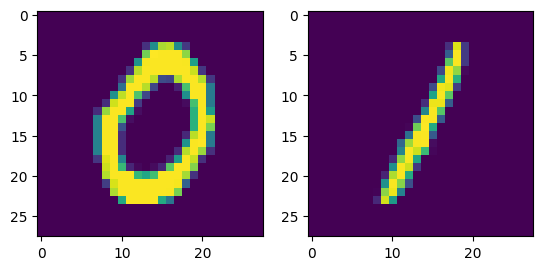

In [ ]:
# costruiamo due dataset con gli eventi MNIST 0 e 1

mnist0 = X_train[Y_train==0]
mnist1 = X_train[Y_train==1]

plt.subplot(1,2,1)
plt.imshow(mnist0[7].reshape((28,28)))
plt.subplot(1,2,2)
plt.imshow(mnist1[11].reshape((28,28)))

In [ ]:
# convertiamo in torch tensor

X0 = torch.Tensor(mnist0).float()
X1 = torch.Tensor(mnist1).float()

# reshape the tensori da (n,784) a (n,1,28,28) come richiesto da conv layer in pytorch

X0 = X0.view((X0.shape[0],1,28,28))
X1 = X1.view((X1.shape[0],1,28,28))

X0_dataset = TensorDataset(X0, X0)

ds0, ds0t = torch.utils.data.random_split(X0_dataset, [int(0.9*len(X0_dataset)), len(X0_dataset) - int(0.9*len(X0_dataset))])

batch_size = 128

from torch.utils.data import TensorDataset, DataLoader

ds0_dl = DataLoader(ds0, batch_size=batch_size, shuffle=True, drop_last=True)

ds0t_dl = DataLoader(ds0t, batch_size=1, shuffle=True, drop_last=True)

ds1 = TensorDataset(X1, X1)
ds1_dl = DataLoader(ds1, batch_size=1, shuffle=True, drop_last=True)



In [ ]:
# Training


# Istanziamo il modello

hidden_channels = 64
latent_dim = 2 #dimensione dello spazio latente z

encoder = Encoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
decoder = Decoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
model_ae = AE(encoder, decoder)

model_ae = model_ae.to(device)

# Loss Binary CrossEntropy (implementata a mano, se si vuole si puo' usare BCELoss pytorch direttamente)
def vae_loss(recon_x, x):
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784))
    return recon_loss

# Optimizer
LR = 1.e-3
opt = torch.optim.Adam(params=model_ae.parameters(), lr=LR, weight_decay=1e-5)

In [ ]:
# Training loop

import time

epochs = 60
hist_loss = []

for epoch in range(epochs):
    t0 = time.time()

    # training step
    model_ae.train()
    train_loss = 0
    counter = 0

    for xb, _ in ds0_dl:
        counter += 1
        xb=xb.to(device)

        xhat = model_ae(xb)
        loss = vae_loss(xhat, xb)

        train_loss += loss.item()

        # backpropagation
        opt.zero_grad()
        loss.backward()
        opt.step()


    train_loss /= counter
    hist_loss.append(train_loss)

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f"
          % (epoch+1, elapsed_time, train_loss))

epoch: 1, time(s): 0.2943, train loss: 0.309073
epoch: 2, time(s): 0.2267, train loss: 0.219616
epoch: 3, time(s): 0.2250, train loss: 0.212726
epoch: 4, time(s): 0.2252, train loss: 0.208233
epoch: 5, time(s): 0.2287, train loss: 0.202164
epoch: 6, time(s): 0.2306, train loss: 0.197822
epoch: 7, time(s): 0.2335, train loss: 0.194211
epoch: 8, time(s): 0.2216, train loss: 0.191675
epoch: 9, time(s): 0.2280, train loss: 0.189594
epoch: 10, time(s): 0.2302, train loss: 0.187772
epoch: 11, time(s): 0.2273, train loss: 0.186008
epoch: 12, time(s): 0.2274, train loss: 0.184961
epoch: 13, time(s): 0.2243, train loss: 0.184074
epoch: 14, time(s): 0.2283, train loss: 0.183345
epoch: 15, time(s): 0.2276, train loss: 0.182564
epoch: 16, time(s): 0.2284, train loss: 0.182426
epoch: 17, time(s): 0.2281, train loss: 0.181614
epoch: 18, time(s): 0.2286, train loss: 0.181366
epoch: 19, time(s): 0.2296, train loss: 0.181108
epoch: 20, time(s): 0.2294, train loss: 0.180910
epoch: 21, time(s): 0.2273, t

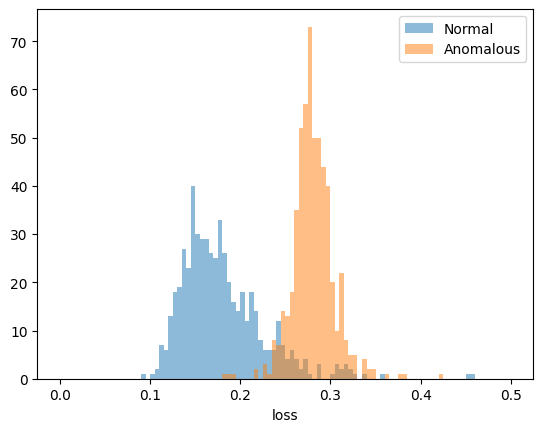

In [ ]:
# Plot distribution of the BCELoss for test 0 and 1 events

model_ae.eval()

ev0_loss = []
ev1_loss = []

with torch.no_grad():
  for xb, _ in ds0t_dl:
    xb=xb.to(device)

    xhat = model_ae(xb)
    loss = vae_loss(xhat, xb)

    ev0_loss.append(loss.item())

  for xb, _ in ds1_dl:
    xb=xb.to(device)

    xhat = model_ae(xb)
    loss = vae_loss(xhat, xb)

    ev1_loss.append(loss.item())

plt.hist(ev0_loss, bins=100, range=[0,0.5], label='Normal', alpha=0.5)
plt.hist(ev1_loss[:len(ev0_loss)], bins=100, range=[0,0.5], label='Anomalous', alpha=0.5)
plt.xlabel("loss")
plt.legend()
plt.show()

## Parte 2: esercizio

modificare il modello usato come AD per i caratteri 0 e 1 per fare anomaly detection su "immagini" (rappresentazioni degli hit rilasciati su un detector di particelle) al passaggio di due tipi di particelle differenti: particelle madri con vita media corta (prompt) che decadono immediatamente in muoni carichi (il cui passaggio è identifcato dal detector di muoni), e particelle madri  con lunga vita media che decadono in muoni dopo aver viaggiato per una distanza macroscopica. Le prime decadono molto lontano dal rivelatore di muoni, le secondo molto vicine a quest'ultimo. I muoni di decadimento nel primo caso arriveranno distribuite in un cono di grande apertura centrato sulla direzione della particella madre, mentre nel secondo caso l'apertura del cono sarà ridotta.

In [ ]:
# scarichiamo e leggiamo il dataset

!wget http://giagu.web.cern.ch/giagu/CERN/data_10v_downsampled.npz

f = np.load('data_10v_downsampled.npz')
data = f['data_noise']
labels = f['labels']

print("data:  ",data.shape)    #data_noise: 10k immagini hit sul detector (10000, 20, 100)=(numero eventi, coordinata radiale, coordinata angolare)
print("labels: ",labels.shape) #label: (10000, 3) = (numero eventi, distanza di decadimento, ...) da usare per selezionare eventi prompt (distanza di decadimento < 1m)
#                               da eventi non prompt anomali (distanza di decadimento > 3m)

--2025-05-11 14:47:07--  http://giagu.web.cern.ch/giagu/CERN/data_10v_downsampled.npz
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.185.50.104, 188.185.5.88, 188.185.18.46, ...
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.185.50.104|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://giagu.web.cern.ch/giagu/CERN/data_10v_downsampled.npz [following]
--2025-05-11 14:47:08--  https://giagu.web.cern.ch/giagu/CERN/data_10v_downsampled.npz
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.185.50.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 480241008 (458M)
Saving to: ‘data_10v_downsampled.npz.1’

data_10v_downsample 100%[===================>] 457.99M  20.9MB/s    in 24s     

2025-05-11 14:47:33 (19.2 MB/s) - ‘data_10v_downsampled.npz.1’ saved [480241008/480241008]

data:   (10000, 20, 100)
labels:  (10000, 3)


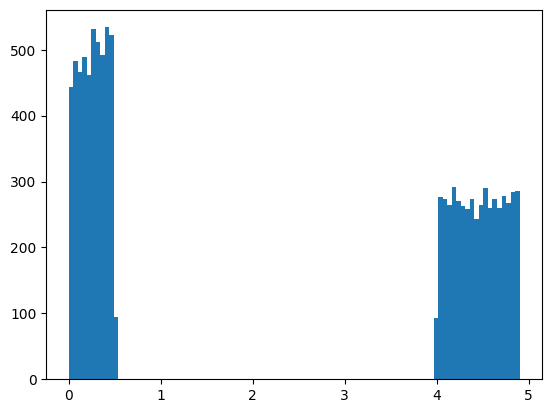

In [ ]:
# distribuzione distanza di decadimento:

import matplotlib.pyplot as plt
_ = plt.hist(labels[:,0], bins=100)

In [ ]:
# preprocessamento:

data[data>0]=1 #rendiamo le immagini binarie (0 assenza di hit nella zona del rivelatore, 1 presenza di un hit)

# dividiamo il campione in eventi normali (dis. di decadimento < 1m) e anomali
labels = labels[:,0]
datax = data[labels<1.0] #eventi normali
datat = datax[:4000] #training
datap = datax[4000:] # test
datad = data[labels>3.0] #eventi anomali (solo test)

print(datat.shape)
print(datap.shape)
print(datad.shape)

(4000, 20, 100)
(1029, 20, 100)
(4971, 20, 100)


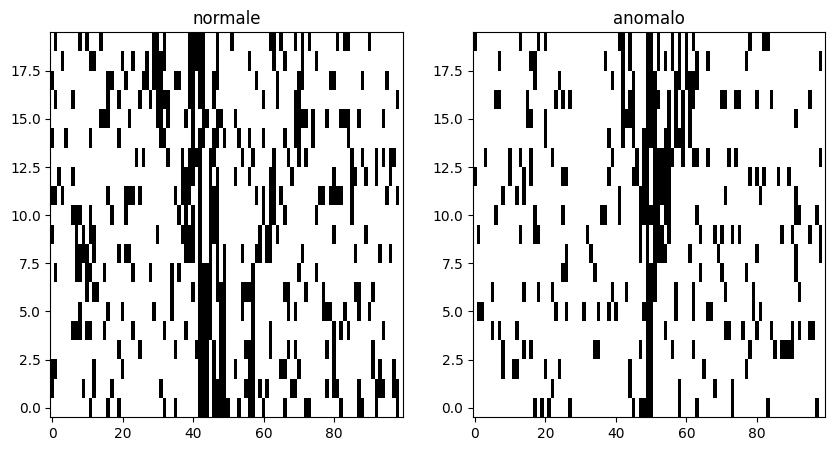

In [ ]:
# esempio di evento normale e di evento anomalo:

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(datat[10], aspect='auto', origin='lower', cmap=plt.cm.binary)
plt.title('normale')
plt.subplot(1,2,2)
plt.imshow(datad[99], aspect='auto', origin='lower', cmap=plt.cm.binary)
plt.title('anomalo')
plt.show()

Da fare:


*   converire gli array numpy in pytorch di shape (N, 1, 20, 100)
*   costruire un AE convoluzionale (suggerimento: encoder: tre blocchi convoluzionali, i primi due con convoluzioni (3,6) e  stride 2 (no pooling),il terzo con stride (1,2), latent dim 2.
*   usare BCELoss()
*   allenare con datat, e testare con datap e datad

In [ ]:
#...

# Soluzione

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import os

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.6.0+cu124


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
datat = np.expand_dims(datat, -1)
datap = np.expand_dims(datap, -1)
datad = np.expand_dims(datad, -1)

datat_pt = torch.Tensor(datat)
datap_pt = torch.Tensor(datap)
datad_pt = torch.Tensor(datad)

datat_pt = datat_pt.permute(0,3,1,2)
datap_pt = datap_pt.permute(0,3,1,2)
datad_pt = datad_pt.permute(0,3,1,2)

print(datat_pt.shape)
print(datap_pt.shape)
print(datad_pt.shape)

torch.Size([4000, 1, 20, 100])
torch.Size([1029, 1, 20, 100])
torch.Size([4971, 1, 20, 100])


In [ ]:
# Convolutional Encoder Model

class Encoder(nn.Module):
    def __init__(self, hidden_channels=64, latent_dim=2):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=hidden_channels*3,
                               kernel_size=(3,6),
                               stride=(2,2))

        self.conv2 = nn.Conv2d(in_channels=hidden_channels*3,
                               out_channels=hidden_channels*2,
                               kernel_size=(3,6),
                               stride=(2,2))

        self.conv3 = nn.Conv2d(in_channels=hidden_channels*2,
                               out_channels=hidden_channels,
                               kernel_size=(3,6),
                               stride=(1,2))

        self.fc_z = nn.Linear(in_features=hidden_channels*2*9,
                               out_features=latent_dim)

        self.activation = nn.ReLU()

    def forward(self, x):

        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.activation(self.conv3(x))

        x = x.view(x.shape[0], -1) #flatten

        z = self.fc_z(x)

        return z

In [ ]:
# Convolutional Decoder Model

class Decoder(nn.Module):
    def __init__(self, hidden_channels=64, latent_dim=2):
        super().__init__()
        self.hidden_channels = hidden_channels

        self.fc = nn.Linear(in_features=latent_dim,
                            out_features=hidden_channels*2*9)

        self.conv3 = nn.ConvTranspose2d(in_channels=hidden_channels,
                                        out_channels=hidden_channels*2,
                                        kernel_size=(3,6),
                                        stride=(1,2))
        self.conv2 = nn.ConvTranspose2d(in_channels=hidden_channels*2,
                                        out_channels=hidden_channels*3,
                                        kernel_size=(3,6),
                                        stride=(2,2))
        self.conv1 = nn.ConvTranspose2d(in_channels=hidden_channels*3,
                                        out_channels=1,
                                        kernel_size=(3,6),
                                        stride=(2,2),output_padding=(1,0))

        self.activation = nn.ReLU()


    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), self.hidden_channels, 2, 9)
        x = self.activation(self.conv3(x))
        x = self.activation(self.conv2(x))
        out = torch.sigmoid(self.conv1(x)) # final activation sigmoid (works with BCELoss as reconstruction loss)
        return out

In [ ]:
# Instanziame e printiamo l'encoder

hidden_channels = 16
latent_dim = 5 #dimensione dello spazio latente z

encoder = Encoder(hidden_channels=hidden_channels, latent_dim=latent_dim)

print(encoder)

from torchsummary import summary
if torch.cuda.is_available():
  summary(encoder.cuda(), input_size=(1,20,100))
else:
  summary(encoder, input_size=(1,20,100))

Encoder(
  (conv1): Conv2d(1, 48, kernel_size=(3, 6), stride=(2, 2))
  (conv2): Conv2d(48, 32, kernel_size=(3, 6), stride=(2, 2))
  (conv3): Conv2d(32, 16, kernel_size=(3, 6), stride=(1, 2))
  (fc_z): Linear(in_features=288, out_features=5, bias=True)
  (activation): ReLU()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 48, 9, 48]             912
              ReLU-2            [-1, 48, 9, 48]               0
            Conv2d-3            [-1, 32, 4, 22]          27,680
              ReLU-4            [-1, 32, 4, 22]               0
            Conv2d-5             [-1, 16, 2, 9]           9,232
              ReLU-6             [-1, 16, 2, 9]               0
            Linear-7                    [-1, 5]           1,445
Total params: 39,269
Trainable params: 39,269
Non-trainable params: 0
----------------------------------------------------------------
Input size 

In [ ]:
# idem per il decoder

decoder = Decoder(hidden_channels=hidden_channels, latent_dim=latent_dim)

print(decoder)

from torchsummary import summary
if torch.cuda.is_available():
  summary(decoder.cuda(), input_size=(1,latent_dim))
else:
  summary(decoder, input_size=(1,latent_dim))


Decoder(
  (fc): Linear(in_features=5, out_features=288, bias=True)
  (conv3): ConvTranspose2d(16, 32, kernel_size=(3, 6), stride=(1, 2))
  (conv2): ConvTranspose2d(32, 48, kernel_size=(3, 6), stride=(2, 2))
  (conv1): ConvTranspose2d(48, 1, kernel_size=(3, 6), stride=(2, 2), output_padding=(1, 0))
  (activation): ReLU()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 288]           1,728
   ConvTranspose2d-2            [-1, 32, 4, 22]           9,248
              ReLU-3            [-1, 32, 4, 22]               0
   ConvTranspose2d-4            [-1, 48, 9, 48]          27,696
              ReLU-5            [-1, 48, 9, 48]               0
   ConvTranspose2d-6           [-1, 1, 20, 100]             865
Total params: 39,537
Trainable params: 39,537
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forwa

In [ ]:
# Full AE Model

class AE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z = self.encoder(x)
        x_reco = self.decoder(z)
        return x_reco

In [ ]:
model_ae = AE(encoder, decoder)

print(model_ae)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model_ae.cuda(), input_size=(1,20,100))
else:
  summary(model_ae, input_size=(1,20,100))

AE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 48, kernel_size=(3, 6), stride=(2, 2))
    (conv2): Conv2d(48, 32, kernel_size=(3, 6), stride=(2, 2))
    (conv3): Conv2d(32, 16, kernel_size=(3, 6), stride=(1, 2))
    (fc_z): Linear(in_features=288, out_features=5, bias=True)
    (activation): ReLU()
  )
  (decoder): Decoder(
    (fc): Linear(in_features=5, out_features=288, bias=True)
    (conv3): ConvTranspose2d(16, 32, kernel_size=(3, 6), stride=(1, 2))
    (conv2): ConvTranspose2d(32, 48, kernel_size=(3, 6), stride=(2, 2))
    (conv1): ConvTranspose2d(48, 1, kernel_size=(3, 6), stride=(2, 2), output_padding=(1, 0))
    (activation): ReLU()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 48, 9, 48]             912
              ReLU-2            [-1, 48, 9, 48]               0
            Conv2d-3            [-1, 32, 4, 22]          27,680
              ReLU-4 

In [ ]:
# dataloaders

from torch.utils.data import TensorDataset, DataLoader

batch_size=32

dataset_tt = TensorDataset(datat_pt,datat_pt)
dataloader_tt = DataLoader(dataset_tt, batch_size=batch_size, shuffle=True, drop_last=True)

dataset_tp = TensorDataset(datap_pt,datap_pt)
dataloader_tp = DataLoader(dataset_tp, batch_size=1)

dataset_td = TensorDataset(datad_pt,datad_pt)
dataloader_td = DataLoader(dataset_td, batch_size=1)

In [ ]:
# test funzionamento su un batch
model_ae=model_ae.to(device)
x,_ = next(iter(dataloader_tt))
model_ae.to(device)
x=x.to(device)
xtilde = model_ae(x)
print(xtilde.shape)

torch.Size([32, 1, 20, 100])


In [ ]:
#loss

loss_func = nn.BCELoss()

# optim
from torch import optim
LR = 1.e-3
opt = torch.optim.Adam(params=model_ae.parameters(), lr=LR, weight_decay=1e-5)

In [ ]:
import time

epochs = 60
hist_loss = []

for epoch in range(epochs):
    t0 = time.time()

    # training step
    model_ae.train()
    train_loss = 0
    counter = 0

    for xb, _ in dataloader_tt:
        counter += 1
        xb=xb.to(device)

        xhat = model_ae(xb)
        loss = loss_func(xhat,xb)

        train_loss += loss.item()

        # backpropagation
        opt.zero_grad()
        loss.backward()
        opt.step()


    train_loss /= counter
    hist_loss.append(train_loss)

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f"
          % (epoch+1, elapsed_time, train_loss))

epoch: 1, time(s): 0.4828, train loss: 0.524593
epoch: 2, time(s): 0.4135, train loss: 0.505730
epoch: 3, time(s): 0.4178, train loss: 0.504407
epoch: 4, time(s): 0.4157, train loss: 0.503537
epoch: 5, time(s): 0.5245, train loss: 0.500940
epoch: 6, time(s): 0.5364, train loss: 0.497861
epoch: 7, time(s): 0.5167, train loss: 0.495564
epoch: 8, time(s): 0.5910, train loss: 0.494032
epoch: 9, time(s): 0.4585, train loss: 0.492660
epoch: 10, time(s): 0.4112, train loss: 0.491939
epoch: 11, time(s): 0.4156, train loss: 0.491395
epoch: 12, time(s): 0.4029, train loss: 0.491011
epoch: 13, time(s): 0.4104, train loss: 0.490621
epoch: 14, time(s): 0.4097, train loss: 0.490351
epoch: 15, time(s): 0.4044, train loss: 0.490110
epoch: 16, time(s): 0.4113, train loss: 0.489893
epoch: 17, time(s): 0.4100, train loss: 0.489655
epoch: 18, time(s): 0.4158, train loss: 0.489514
epoch: 19, time(s): 0.4184, train loss: 0.489344
epoch: 20, time(s): 0.4136, train loss: 0.489239
epoch: 21, time(s): 0.4154, t

In [ ]:
# calcolo Anomaly Score
an_s = loss_func #uso la binary crossentropy come distanza (visto che è la loss con cui è stata allenato l'AE)
model_ae.to(device)

as_tp = []
as_td = []
for xb, _ in dataloader_tp:
  xb=xb.to(device)
  pred_tp = model_ae(xb)
  res = an_s(pred_tp,xb)
  as_tp.append(res.item())

for xb, _ in dataloader_td:
  xb=xb.to(device)
  pred_td = model_ae(xb)
  res = an_s(pred_td,xb)
  as_td.append(res.item())

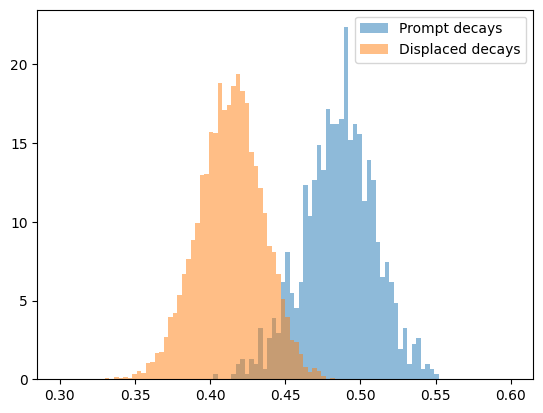

In [ ]:
import matplotlib.pyplot as plt

_ = plt.hist(as_tp,bins=100, alpha=0.5, density=True, range=[0.3,0.6], label='Prompt decays')
_ = plt.hist(as_td,bins=100, alpha=0.5, density=True, range=[0.3,0.6], label='Displaced decays')
plt.legend()
plt.show()